In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import json

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

params = json.loads(open('../params.json', 'r').read())

# Date range
start = "2017-01-01"
end = "2023-11-19"

# Tickers of assets
industry_asset = json.loads(open('../stocks.json', 'r').read())
assets = []
for key, values in industry_asset.items():
    for value in values:
        assets.append(value)

# Overwriting assets
assets = ['VALE3.SA', 'CPFE3.SA', 'CMIG3.SA', 'ELET3.SA', 'EGIE3.SA']
        
# Downloading data
data = yf.download(assets, start=start, end=end, interval="1mo")

[*********************100%%**********************]  5 of 5 completed


In [2]:
from ta import trend, volume as volume_ta, momentum

THRESHOLD = 5

def get_trend(data_prices, i):
    trend = float(0.5)
    if 100 * (data_prices[i] / data_prices[i-1]) - 100 >= THRESHOLD:
        trend = float(1.0)
    elif 100 * (data_prices[i] / data_prices[i-1]) - 100 <= 0:
        trend = float(0.0)
    return trend

def get_trend_open(data_open, data_close, i):
    trend = float(0.5)
    if 100 * (data_open[i] / data_close[i-1]) - 100 >= THRESHOLD:
        trend = float(1.0)
    elif 100 * (data_open[i] / data_close[i-1]) - 100 <= 0:
        trend = float(0.0)
    return trend

def is_the_last_date(i, size):
    return i == size-1

indicators = {
    asset: {
        "date": [],
        "open": [],
        "close": [],
        "high": [],
        "low": [],
        "volume": [],
        "trend_open": [],
        "trend_close": [],
        "trend_high": [],
        "trend_low": [],
        "next_trend_open": [],
        "next_trend_close": [],
        "next_trend_high": [],
        "next_trend_low": [],
        "aroon": [],
        "aroon_down": [],
        "aroon_up": [],
        "cmf": [],
        "mfi": [],
        "ppo": [],
        "pvo": [],
        "rsi": [],
        "stc": [],
        "volume_rsi": [], 
        "williamsr": []
    }
    for asset in assets
}

dates = [d.to_pydatetime().strftime('%Y-%m-%d %H:%M:%S') for d in data.index]

for asset in assets:
    if int(dates[0][0:4]) > 2018:
        print(f"{int(dates[0][0:4])} is too new, skipping it.")
        continue

    high = data["High"][asset].astype(float)
    low = data["Low"][asset].astype(float)
    open = data["Open"][asset].astype(float)
    close = data["Close"][asset].astype(float)
    volume = data["Volume"][asset].astype(float)

    # AROON indicator
    aroon = trend.AroonIndicator(high, low).aroon_indicator()
    aroon_down = trend.AroonIndicator(high, low).aroon_down()
    aroon_up = trend.AroonIndicator(high, low).aroon_up()

    # CMF indicator
    indicator_calc = volume_ta.ChaikinMoneyFlowIndicator(high, low, close, volume)
    cmf = indicator_calc.chaikin_money_flow()

    # MFI indicator
    mfi = volume_ta.MFIIndicator(high, low, close, volume).money_flow_index()

    # PPO indicator
    indicator_calc = momentum.PercentagePriceOscillator(close)
    ppo = indicator_calc.ppo()

    # PVO indicator
    indicator_calc = momentum.PercentageVolumeOscillator(volume)
    pvo = indicator_calc.pvo()

    # RSI indicator
    rsi = momentum.RSIIndicator(close).rsi()

    # STC indicator
    stc = trend.STCIndicator(close, 12, 5, 3, 3, 3).stc()

    # VOLUME RSI indicator
    volume_rsi = momentum.RSIIndicator(volume).rsi()

    # WILLIAMS R indicator
    williamsr = momentum.WilliamsRIndicator(high, low, close).williams_r()

    data_len = len(williamsr)

    first_not_nan = True
    for i in range(1, data_len):
        if (
            not np.isnan(aroon[i]) and
            not np.isnan(aroon_up[i]) and
            not np.isnan(aroon_down[i]) and
            not np.isnan(cmf[i]) and
            not np.isnan(mfi[i]) and
            not np.isnan(ppo[i]) and
            not np.isnan(pvo[i]) and
            not np.isnan(rsi[i]) and
            not np.isnan(stc[i]) and
            not np.isnan(volume_rsi[i]) and
            not np.isnan(williamsr[i])
        ):
            if first_not_nan:
                first_not_nan = False
                continue

            trend_high = get_trend(high, i)
            trend_low = get_trend(low, i)
            trend_open = get_trend_open(open, close, i)
            trend_close = get_trend(close, i)

            next_trend_high = float(0.0) if is_the_last_date(i, data_len) else get_trend(high, i+1)
            next_trend_low = float(0.0) if is_the_last_date(i, data_len) else get_trend(low, i+1)
            next_trend_open = float(0.0) if is_the_last_date(i, data_len) else get_trend_open(open, close, i+1)
            next_trend_close = float(0.0) if is_the_last_date(i, data_len) else get_trend(close, i+1)

            indicators[asset]["date"].append(dates[i])
            indicators[asset]["high"].append(high[i])
            indicators[asset]["low"].append(low[i])
            indicators[asset]["open"].append(open[i])
            indicators[asset]["close"].append(close[i])
            indicators[asset]["volume"].append(close[i])
            indicators[asset]["aroon"].append(aroon[i])
            indicators[asset]["aroon_down"].append(aroon_down[i])
            indicators[asset]["aroon_up"].append(aroon_up[i])
            indicators[asset]["cmf"].append(cmf[i])
            indicators[asset]["mfi"].append(mfi[i])
            indicators[asset]["ppo"].append(ppo[i])
            indicators[asset]["pvo"].append(pvo[i])
            indicators[asset]["rsi"].append(rsi[i])
            indicators[asset]["stc"].append(stc[i])
            indicators[asset]["volume_rsi"].append(volume_rsi[i])
            indicators[asset]["williamsr"].append(williamsr[i])
            indicators[asset]["trend_high"].append(trend_high)
            indicators[asset]["trend_low"].append(trend_low)
            indicators[asset]["trend_open"].append(trend_open)
            indicators[asset]["trend_close"].append(trend_close)
            indicators[asset]["next_trend_high"].append(next_trend_high)
            indicators[asset]["next_trend_low"].append(next_trend_low)
            indicators[asset]["next_trend_open"].append(next_trend_open)
            indicators[asset]["next_trend_close"].append(next_trend_close)

In [3]:
from sklearn.preprocessing import MinMaxScaler

indicators_reshaped = {
    asset: {
        "open": [],
        "close": [],
        "high": [],
        "low": [],
        "volume": [],
        "trend_open": [],
        "trend_close": [],
        "trend_high": [],
        "trend_low": [],
        "next_trend_open": [],
        "next_trend_close": [],
        "next_trend_high": [],
        "next_trend_low": [],
        "aroon": [],
        "aroon_down": [],
        "aroon_up": [],
        "cmf": [],
        "mfi": [],
        "ppo": [],
        "pvo": [],
        "rsi": [],
        "stc": [],
        "volume_rsi": [], 
        "williamsr": []
    }
    for asset in assets
}

indicators_scaled = {
    asset: {
        "trend_open": [],
        "trend_close": [],
        "trend_high": [],
        "trend_low": [],
        "aroon": [],
        "aroon_down": [],
        "aroon_up": [],
        "cmf": [],
        "mfi": [],
        "ppo": [],
        "pvo": [],
        "rsi": [],
        "stc": [],
        "volume_rsi": [], 
        "williamsr": []
    }
    for asset in assets
}

indicators_scalers = {
    asset: {
        "trend_open": None,
        "trend_close": None,
        "trend_high": None,
        "trend_low": None,
        "aroon": None,
        "aroon_down": None,
        "aroon_up": None,
        "cmf": None,
        "mfi": None,
        "ppo": None,
        "pvo": None,
        "rsi": None,
        "stc": None,
        "volume_rsi": None, 
        "williamsr": None
    }
    for asset in assets
}

for asset in assets:
    # Reshape data
    for index, row in indicators[asset].items():
        if index not in ["date"]:
            indicators_reshaped[asset][index] = np.array(row)
            indicators_reshaped[asset][index] = indicators_reshaped[asset][index].reshape(-1, 1)

    # Create scalers
    for index, row in indicators_scalers[asset].items():
        indicators_scalers[asset][index] = MinMaxScaler(feature_range=(0, 1))

    # Discretize data
    for index, row in indicators_reshaped[asset].items():
        if index not in ["open", "close", "high", "low", "volume", "next_trend_open", "next_trend_close", "next_trend_high", "next_trend_low"]:
            indicators_scaled[asset][index] = indicators_scalers[asset][index].fit_transform(indicators_reshaped[asset][index])

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf

keras = tf.keras

prediction_assets = []
prediction_high = []
prediction_low = []
prediction_open = []
prediction_close = []

for asset in assets:
    # This is related to the filter about the data being too new (> 2018)
    if len(indicators[asset]["date"]) == 0:
        continue
    
    model_input = [
        indicators_scaled[asset]["trend_high"][-1],
        indicators_scaled[asset]["trend_low"][-1],
        indicators_scaled[asset]["trend_open"][-1],
        indicators_scaled[asset]["trend_close"][-1],
        indicators_scaled[asset]["aroon"][-1],
        indicators_scaled[asset]["aroon_down"][-1],
        indicators_scaled[asset]["aroon_up"][-1],
        indicators_scaled[asset]["cmf"][-1],
        indicators_scaled[asset]["mfi"][-1],
        indicators_scaled[asset]["ppo"][-1],
        indicators_scaled[asset]["pvo"][-1],
        indicators_scaled[asset]["rsi"][-1],
        indicators_scaled[asset]["stc"][-1],
        indicators_scaled[asset]["williamsr"][-1]
    ]
    
    prediction_assets.append(asset)
    
    model = keras.models.load_model(f"trained-models/{asset}_high")
    prediction = model.predict(np.array([model_input]), verbose=0)
    prediction_high.append(round(prediction[0][0], 1))
                                         
    model = keras.models.load_model(f"trained-models/{asset}_low")
    prediction = model.predict(np.array([model_input]), verbose=0)
    prediction_low.append(round(prediction[0][0], 1))          
                                         
    model = keras.models.load_model(f"trained-models/{asset}_open")
    prediction = model.predict(np.array([model_input]), verbose=0)
    prediction_open.append(round(prediction[0][0], 1))
                                         
    model = keras.models.load_model(f"trained-models/{asset}_close")
    prediction = model.predict(np.array([model_input]), verbose=0)
    prediction_close.append(round(prediction[0][0], 1))

2023-11-20 15:13:00.683153: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


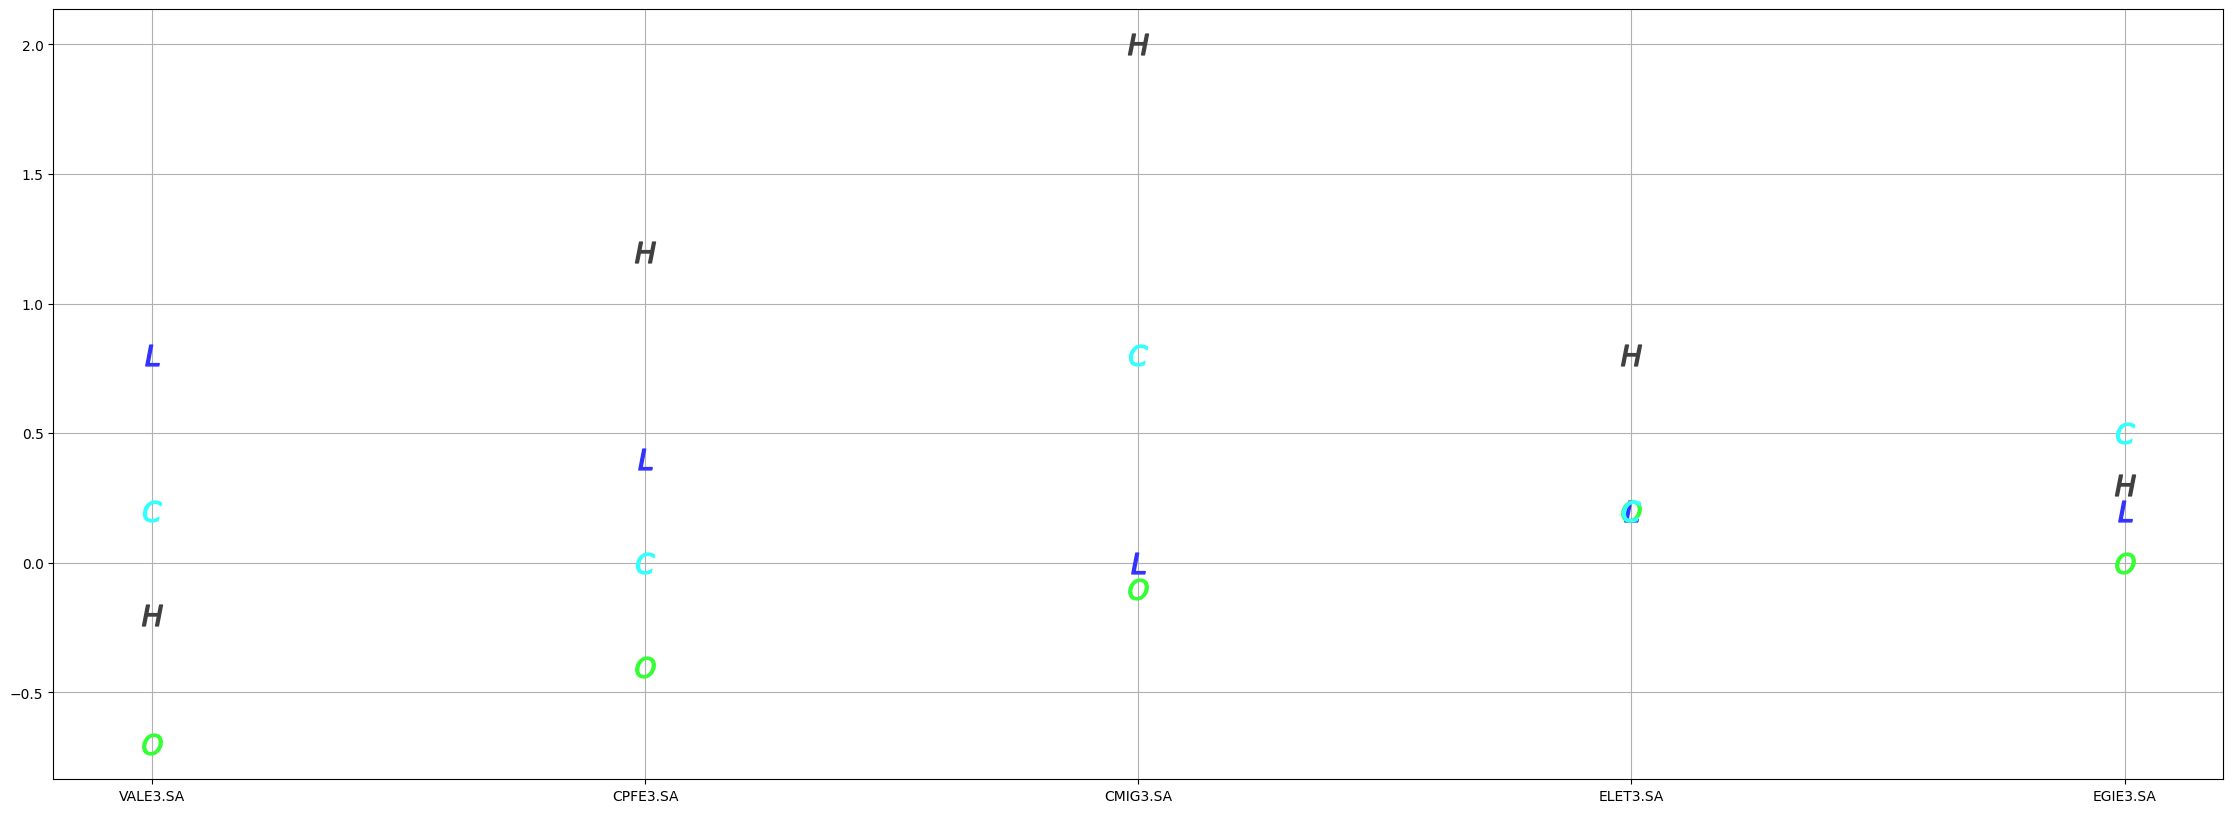

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (28,10)

plt.plot(prediction_assets, prediction_high, color='#404040', marker='$H$', linestyle='', ms=15)
plt.plot(prediction_assets, prediction_low, color='#3333FF', marker='$L$', linestyle='', ms=15)
plt.plot(prediction_assets, prediction_open, color='#33FF33', marker='$O$', linestyle='', ms=15)
plt.plot(prediction_assets, prediction_close, color='#33FFFF', marker='$C$', linestyle='', ms=15)
plt.grid()
plt.show()
